## Pre-Preliminary Version

### Sampling Methods for Class Imbalance Issues

#### Project for the Statistical Modelling Course - Felix Adam

When used properly, statistical classification can help to tackle all sorts of problems: identifiyng fraud, rare diseases or excellent products. However, problems can arise, when the class of interest is severily underrepresented in the data.

- Often the case that the class of interest, is severely underrepresented in the data
- Also called the "minority" class
- Example: Dataset on rare disease, which is found in 10 out of 1000 people
- Let's say we apply logistic regression to this problem to classify patients in healty and unhealty
- Use the dataset of 1000 observations, have some features, fit logistic regression
- Then we test the accuracy, it turns out to be very high lets's say 99% correctly predicted
- Is this a good classifier? We have to check whether the 99% are actually meaningful
- Potential issue: Classifier assigns every patient to the healthy class, which still results in accuracy of 99%
- Naive approach would be to ditch the classifier and just tell everyone that they're healthy, potentially devestating results
- The issue: With such an imbalanced dataset, classifiers tend to perform badly, since they 'learn' the features of the majority class


Ironically, predicting rare events is one of the most important and interesting tasks in classification. Luckily, there are some techniques for dealing with class imbalances. 

I will first discuss the issues that arise when not accounting for class imbalances. Then I'll present undersampling of the majority class as simple remedy. I will later extend this method to synthetic oversampling using the Synthetic Minority Oversampling Technique (SMOTE). In the last section I'll discuss further applications, benefits and shortfalls of the presented techniques and other options available.

0. The data

1. Demonstrate the issue using the wine example
    
    - Logistic regression seemingly performs well when checking accuracy
    - Horrible performance in total, only able to classify "uninteresting classes"
    - Discussion of ROC, AUC and general assessment of classifiers
    - Aiming for high AUC!
    - -> Good general performance!
    - Provost and Fawcett (1997): Convex hull
    
2. Re-Sampling Methods with application in logistic regression
    - Crucial to reweight the learned probabilities!
    - Check also, what is the intercept?

2. Simple resampling: Undersampling of the majority class

    - Discuss method
    - Methodology, idea behind it -> Theory
    - Show performance compared to base case

3. Extension: SMOTE

    - Theory, methodology
    - Discuss
    - Implement and show performance

4. Discussion: Which method should be used?

    - What about just moving the descision boundary? (Also mentioned in the SMOTE paper)
    - Benefits/ Shortfalls
    

#### Notes

- Issue of PREDICTION 
- Aim of this doc is to present sampling methods, not classifiers
- No information rate (see book, page 255)
- CV done false: Check your CV set up
- When are you using sampling techniques? Before or after CV?
- CV at all?

Consider testing under-sampling when you have an a lot data (tens- or hundreds of thousands of instances or more)
Consider testing over-sampling when you don’t have a lot of data (tens of thousands of records or less)
Consider testing random and non-random (e.g. stratified) sampling schemes.

#### This is important
Consider testing different resampled ratios (e.g. you don’t have to target a 1:1 ratio in a binary classification problem, try other ratios)
        - Play around with different ratios, try to get the optimum, however, try on training set
        - Maybe also shows overfitting in the end!


##### Setting up the environment

In [6]:
%matplotlib inline

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import datasets
import itertools
from sklearn.utils import shuffle

# Function for making gaussian classification problem
def make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_min, seperation, sd_majority, cov_maj):
    
    """Helper function for creating classification problem with gaussians"""
    # Split into majority and minority sizes
    n_minority = int(base_rate * n)
    n_majority = int((1-base_rate)* n)
        
    # Get mean of majority from seperation parameter
    mean_majority = seperation * mean_minority
    
    # Assign covariance matrices
    cov_minority = np.array([[sd_minority[0],cov_min], [cov_min,sd_minority[1]]])
    cov_majority = np.array([[sd_majority[0],cov_maj], [cov_maj,sd_majority[1]]])
    
    # Make 2d multivariate for minortiy and majority class, assign classes
    x_minority = np.random.multivariate_normal(mean_minority,cov_minority, check_valid ='warn', size = n_minority)
    y_minority = np.ones(n_minority)
    
    x_majority = np.random.multivariate_normal(mean_majority,cov_majority, check_valid ='warn', size = n_majority)
    y_majority = np.zeros(n_majority)
    
    # Concatenate both to arrays
    x = np.concatenate((x_minority,x_majority),axis = 0)
    y = np.concatenate((y_minority,y_majority), axis = 0)
    
    # Shuffle
    x,y = shuffle(x,y)
        
    # Return arrays
    return x, y

# Helper function for plotting 
def plot_2d(X,y, title = ''):
    
    fig, ax = plt.subplots(1,1, figsize = (10,8))
    ax.scatter(X[:,0], X[:,1], c= y, alpha = 0.8, edgecolor='k')
    
    # Prettify
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

# Helper function for plotting the confusion matrix
def plot_confusion(cnf_matrix, classes = ['Normal Wine','Bad Wine'], title = 'Confusion Matrix', cmap = plt.cm.Blues):
    
    " Helper function for plotting a confusion matrix"
    # Make heatmap plot
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Title, colorbar and tickmarks
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Write number of predictions in matrix
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if cnf_matrix[i, j] > thresh else "black")
    
    # Add labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

##### Data Generation 

- Use artificially generated data to demonstrate the different sampling techniques
- Some canoncial examples in 2-d for demonstration
- This is not about variable selection, i will generate data so that all features are relevant
- This also helps to asses whether logistic regression learns the right thing
- Undersample at different levels!

Some canonical problems:
- Gaussian
- Circles
- Spirals

In [243]:
# Function for making gaussian classification problem
def make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_min, seperation, sd_majority, cov_maj):
    
    """Helper function for creating classification problem with gaussians"""
    # Split into majority and minority sizes
    n_minority = int(base_rate * n)
    n_majority = int((1-base_rate)* n)
        
    # Get mean of majority from seperation parameter
    mean_majority = seperation * mean_minority
    
    # Assign covariance matrices
    cov_minority = np.array([[sd_minority[0],cov_min], [cov_min,sd_minority[1]]])
    cov_majority = np.array([[sd_majority[0],cov_maj], [cov_maj,sd_majority[1]]])
    
    # Make 2d multivariate for minortiy and majority class, assign classes
    x_minority = np.random.multivariate_normal(mean_minority,cov_minority, check_valid ='warn', size = n_minority)
    y_minority = np.ones(n_minority)
    
    x_majority = np.random.multivariate_normal(mean_majority,cov_majority, check_valid ='warn', size = n_majority)
    y_majority = np.zeros(n_majority)
    
    # Concatenate both to arrays
    x = np.concatenate((x_minority,x_majority),axis = 0)
    y = np.concatenate((y_minority,y_majority), axis = 0)
    
    # Shuffle
    x,y = shuffle(x,y)
        
    # Return arrays
    return x, y

#### The Problem
- generate some basic data using the gaussian function
- Severly undersample
- Show metrics-> Confusion matrix, precision, recall, ROC & AUC
- Show decsision boundary

#### Generating simple example
- base rate 0.02
- relatively good, linear split not too far apart but distinct
- "Two parallel distributions"

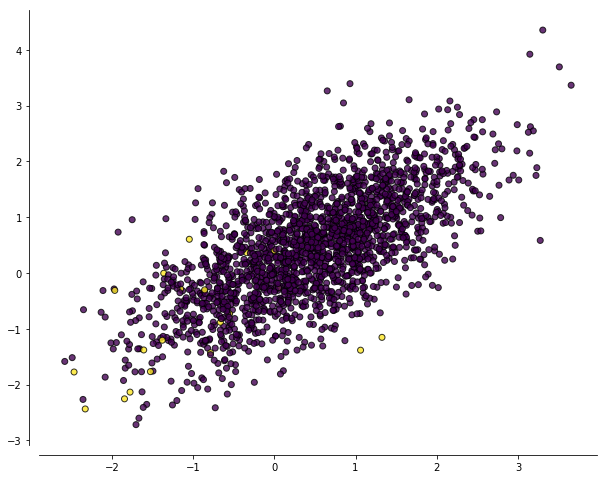

In [281]:
## Making the data ##

# Base rate and sample size
base_rate = 0.01
n = 2000

# Properties of the minority class distribution
mean_minority =  np.array([-1,-1])
sd_minority = np.array([1,1])
cov_minority = 0.7

# Seperation parameter
seperation = -0.5

# Majority class parameters
sd_majority = np.array([1,1])
cov_majority = 0.7

# Make distribution and classes
x, y = make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_minority, seperation,
                        sd_majority,cov_majority)

# Plot
plot_2d(x,y)

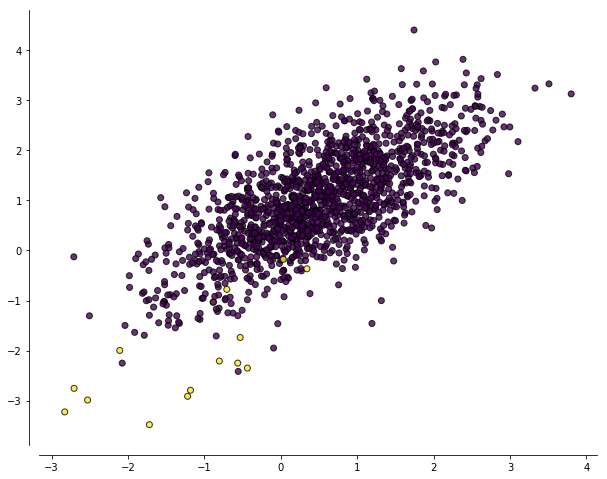

In [277]:
## Train test, split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, stratify = y )

# Show distribution of training sample
plot_2d(X_train,y_train)

#### 2. Estimation Set-Up

- Estimation using logistic regression
- $ P(y = 1|x)$ where $y$ is the class, and $x$ are the features
- In logistic regression, this probability can be modeled using the logg odds: 


$$\log {\frac{P(y = 1 \mid x)}{P(y = 0 \mid x)}} = X^T  \beta $$

- $\beta$ is the vector of parameters to be estimated, contains a constant  
- Then, a logistic transformation can be used to achieve $y \in (0,1)$ 


$$P( y = 1 \mid x) = \frac{1}{1+e^{-\phi(x^T)\beta}}$$


- Always fit intercept 

- Make a training and testing data set, stratified
- All methods will be applied on the same training data set (under-, oversampling, smote)
- Final step: Use testing data-set to show performance

#### 2. Baseline Model

I will no start with the baseline logistic regression model without any application of sampling methods, using pythons sklearn library. 

- Fit logit model using all features, variable selection not focus
- Fit intercept
- Sklearn has by default a regularization parameter, in this case l1 norm
- C specifies $1/\lambda$, smaller values result in dropping of regularization term
- Using same model all the time! No regularization / cv? 
- Important for comparability (?)

In [278]:
# Instantiate the model, intercept,no class weights (default), 'l1' penalty essentially removed
baseline_model = LogisticRegression(C = 1e4,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model
baseline_model.fit(X_train,y_train);

- Seemed like a fairly straightforward process
- One could imagine that this is all fairly easy
- Now it's time to access the model performance

##### Assessing Model Performance

- Will analyze various metrics, starting with accuracy
- Use the testing set and make predictions on it
- Record predictions, compare with acutal class
- Potentially better to do cross validation as well?
- See cross-val score

Overall accuracy rate is calculated as the number of true negatives ($\text{TN}$) plus true positives ($\text{TP}$) divided by all classifications made

$$\text{accuracy} = \frac{tp + tn}{n} $$



Sklearns metrics library comes with many built in scoring methods.
General process: 
- make predictions 
- question here: which cut-off should i use?
- Completely naive approach: Set decision boundary to 0.5
- Will later discuss the first potential remedy: Moving the decision boundary

In [279]:
# Now make probability predictions
baseline_proba = baseline_model.predict_proba(X_test)[::,1]

# Set decision boundary, will be used for all subsequent analysis (?)
boundary = 0.5

# Turn probabilistic predictions into class predictions
baseline_pred = [1 if p >= boundary  else 0 for p in baseline_proba]

# Accuracy
accuracy_baseline = metrics.accuracy_score(y_test,baseline_pred)

print('Baseline accuracy score: ' + str(round(accuracy_baseline,4)))

Baseline accuracy score: 0.992


The accuracy score of {{round( accuracy_baseline \* 100,2)}} percent looks great at first. After all, roughly 96 percent of the wines have been classified correctly. 

- Will now try to show a more nuanced view of the whole situation

##### Confusion Matrix

- Useful tool to evaluate class predictions is the confusion matrix (Kuhn & Johnson, 2013)
- Table of predictde and observed classes

In [272]:
cnf_example = pd.DataFrame({'Predicted Negative':['TN', 'FN'],
                           'Predicted Positive':['FP', 'TP'],
                           'Actual \ Pred.' :['Real Negative', 'Real Positive']})
cnf_example.set_index('Actual \ Pred.', inplace= True)
display(cnf_example)

,Predicted Negative,Predicted Positive
Actual \ Pred.,,
Real Negative,TN,FP
Real Positive,FN,TP


- Values on the diagonal represent correct predictions 
- Values on the off diagonal are erros
- One can now notice, that overall accuracy doesn't take type of erorr into account
- Confusion matrix for the baseline model on the testing set

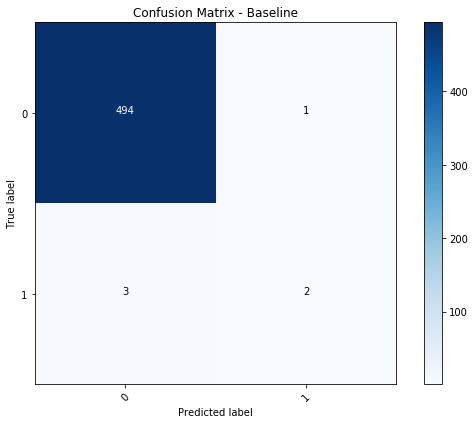

In [280]:
# Set plot size
plt.rcParams['figure.figsize'] = (8,6)

# Get confusion matrix using sklearn metrix
cnf_matrix = metrics.confusion_matrix(y_test,baseline_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Baseline', classes= ['0','1'])

- Now the issue becomes clear, the great accuracy is driven by predicting that almost all wines belong to the average quality class
- The classifier only labels one wine of the bad quality class correctly, and misses the remaining 36 bad wines
- Interestingly, 2 avg. wines are being predicted to be of bad quality -> Indicating bad model?
- This shows, that using accuracy can be very misleading when assessing the performance of a classifier
- Issue of class imbalance, what does logistic regression learn? 
- Logistic regression learns properties of the majority class, becomes very good at predicting normal cases

So which metrics should one look at?
- Precision and Recall

##### Recall / Sensitivity


$$\text{Recall} = P[\hat{y} = 1 \mid y = 1 ]$$


which is in this case 

$$\text{Recall} = \frac{TP}{TP + FN}$$

- Probability of predicting that a given wine has bad quality, given that the wine is actually of bad quality 
- in this case the sensitvity is {{round(metrics.recall_score(y_test,baseline_pred),2)}}
- Only 1 of the 37 bad wines has been classified  correctly

##### Precision


$$\text{ Precision } = P [ y = 1 \mid \hat { y } = 1 ]$$

which is

$$\text{Precision} = \frac{TP}{TP + FP}$$

- Probability that a wine which has been predicted bad, is actually bad
- in this case precision is {{round(metrics.precision_score(y_test,baseline_pred),2)}}

##### False Positive Rate -> For ROC important

$$\text{FPR} = P[ \hat{y} = 1 \mid y = 0 ] $$

$$\text{FPR} = \frac{FP}{TN+FP}$$

- Probability of wrongly predicting a wine to be bad, given that it's normal


Which metric is important?

- If it's important that all positive samples are correctly predicited, true positive / sensitivity is important
- However this could be at the expense of many false positive predictions, e.g. classify everything as positive, results in 100% sensitivity, even though there might be many false positives, which are not captured by sensitivity!
- This would be shown in a very high false positive rate
- Depends ultimately on the issue at hand
- If costs of missing the important class are very high, than focus on sensitvity, e.g. patient would die if disease not noticed, but cost of confirming that patient actually has the disease (capturing more false positives) are low
- If costs of classifying false positive are high, e.g. high mental stress for patient, costly secondary testing procedures, other way around

Scores in this case are calculated statically, on one specific cut off for the linear classifier

-> What happens if we vary the decsision boundary?

- Introduction of the ROC curve

#####  ROC & AUC

In [83]:
metrics.balanced_accuracy_score(y_test,baseline_pred)

0.6617647058823529



- AUC is an accepted traditional performance metric for a ROC Curve (SMOTE Paper),Duda, Hart, & Stork, 2001; Bradley, 1997; Lee, 2000)
- ROC Convex Hull?

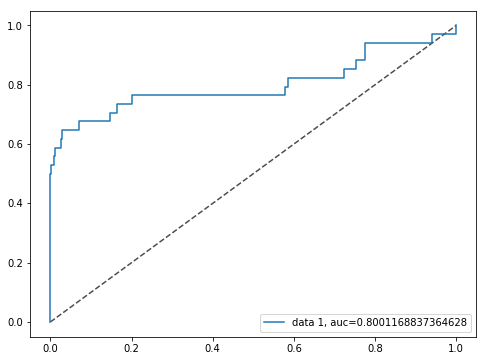

In [85]:
y_pred_proba = baseline_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Random Oversampling


However, in reality, dealing with class imbalances is not just about using different sampling techniques. Rather, as discussed by Weiss (2013), one should first focus on the underlying data-issues at hand. Weiss (2013) mentions problem-definition-level issues, data-level issues and algorithm-level issues. In this set-up, it would be sensible to gather more data on wine-quality in general, or explore different algorithms. 
- Also variable selection and feature 


In [113]:
from imblearn import over_sampling 
ros = over_sampling.RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)

# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
oversampled_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True, class_weight='balanced')

# Fit the model 
oversampled_model.fit(X_oversampled, y_oversampled );

##### NOW RE-WEIGHT THE LEARNED PROBABILITES!!! EXTREMLY IMPORTANT TO CHECK HERE #####

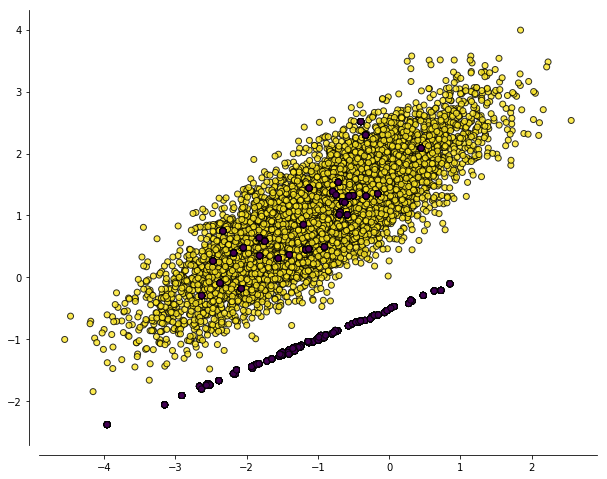

In [114]:
plot_2d(X_oversampled,y_oversampled)

#### Prior correction

- Having used the oversampled sample, need to adjust prior probabilities. 
- Luckily, this only means adjusting the intercept

In [115]:
def correct_intercept_logit(fitted_model, population_y, sample_y):
    
    """ Helper funcion for correcting the intercept of a logit model after re-sampling.
        Both population inputs should be 0-1 class labels, where 1 is the class of interest""" 
    
    # Get the current intercept
    current_intercept = fitted_model.intercept_
    
    # Get population values, estimate them as averages from the population sample
    tau = sum(population_y) / len(population_y)
    
    # Resampled population values
    y_bar = sum(sample_y) / len(sample_y)
    
    # Calculate corrected coefficient 
    corrected_intercept = current_intercept - np.log( ((1-tau) / tau) * (y_bar / (1-y_bar)))
    
    # Set model intercept to corrected intercept
    fitted_model.intercept_ = corrected_intercept

In [116]:
correct_intercept_logit(oversampled_model, y_train, y_oversampled)

#### Simple Over / Undersampling using balancing

In [117]:
# Make predictions on testing values
y_pred_oversampled = oversampled_model.predict(X_test)

# Accuracy
accuracy = metrics.accuracy_score(y_test,y_pred_oversampled)
print(accuracy)

metrics.confusion_matrix(y_test,y_pred_oversampled)

0.9852


array([[   0,   37],
       [   0, 2463]])

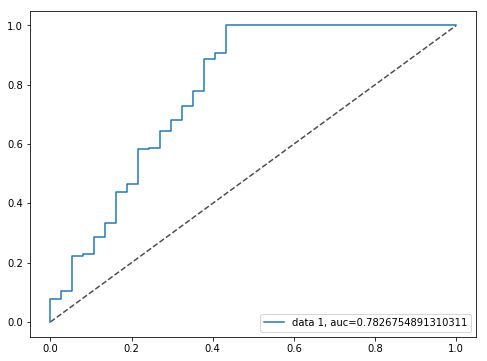

In [118]:
y_over_proba = oversampled_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_over_proba)
auc = metrics.roc_auc_score(y_test, y_over_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Random Under-Sampling of the majority class

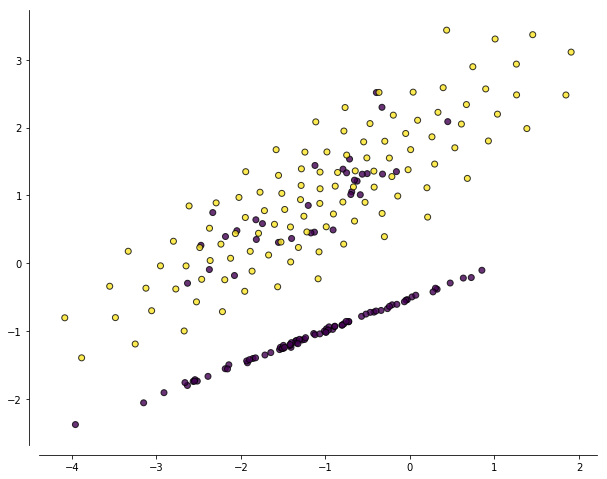

In [119]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_undersampled, y_undersampled = cc.fit_resample(X_train, y_train)

# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
undersampled_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True, class_weight='balanced')

# Fit the model 
undersampled_model.fit(X_undersampled, y_undersampled);

plot_2d(X_undersampled, y_undersampled)
# Adjust intercept

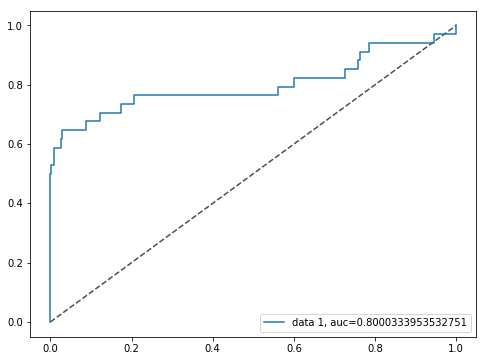

In [98]:
y_under_proba = undersampled_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_under_proba)
auc = metrics.roc_auc_score(y_test, y_under_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### SMOTE Chawla et al (2002)

##### Abstract
- Approach for dealing with imbalanced datasets
- Imbalance: Not equal representation of classification categories
- Happens often in the real world
- Cost of misclassifying an "interesting" example are a lot higer than misclassifying "normal" examples
- Paper shows a combination of over-sampling the minority class and under-sampling the majority class
- This can achive better performance in ROC space than only under-sampling the majority class
- Method involves creating synthetic minority class examples

##### Introduction

- Imbalance of order 100 to 1 can be found in fraud detection 
- others report imbalances of up to 100.000 to 1 (Provost & Fawcett, 2001)
- Performance is often evaluated using predictive accuracy 
- Not appropriate when data is imbalanced and/or costs of different errors vary 
- Example: Cancer prediction / mammography 
- In the case of severe imbalance, a simple strategy of always predicting the majority class would give an almost perfect predicitve accuracy
- Simple predictive accuracy is not appropriate in such situations!
- AUC is an accepted tradional performance metric 
-  ROC Convex Hull -> Very interesting, check it out!

How has the machine learning community addressed the issue of class imbalance?
- Assign distinct costs to training examples
- Re-sample the original dataset
        - Either over sample the minority class
        - And / Or under-sample the majority class
    
Approach presented in the paper uses under-sampling of the majority class with a special form of over-sampling of the minority class

##### Performance Measures
- Performance is typically evaluated by a confusion matrix
- In the context of balanced datasets and equal error costs, it is reasonable to use error the error rate as a performance metric
$$ error = 1- Accuracy$$

- In presence of imbalanced datasets with unequal error costs, more appropriate to use the ROC curve
- ROC curves can be thought of as representing the family of best decision boundaries for relative costs of TP and FP
- X axis: % False positives
- Y axis: % True positives
- Ideal point on the ROC curve would be (0,100), all positive examples are classified correctly and no negative examples are misclassified as positive
- One way a ROC curve can be swept out is by manipulating the balance of training samples for each class in a training set

##### Previous Work: Imbalanced datasets 
- Kubat and Matwin (1997) selectively under-sample the majority class while keeping the original population of the minority class
- Minority examples were divided into four categories: Some noise overlapping the positive class descision regon, borderline samples, redundant samples and safe samples
- Ling and Li (1998): Combine over-sampling the minority class with under-sampling the majority class
- used lift analysis instead of accuracy
- lift curve is more similar to an ROC curve, but more tailored to marketing
- Solberg and Solberg (1996): Oil-slick classification, balance 50-50, achieved 14% error rate on the interesting samples and 4 % error on the "negative" samples
- Precision and recall

*Literature summary: Under-sampling the majority class enables better classifiers to be built than over-sampling the minority class!*
-> Very interesting summary, check?
- Combination of the two as done in previous work does not lead to classifiers that outperform those built with undersampling of majority
- Oversampling of the minority class has been donw by sampling with replacement from the original data, this might be an issue -> SMOTE

#### SMOTE

- Previous research discussed over-sampling with replacment and showed that it doesn't significantly improve minority class recognition
- Authors argue with underlying effect in terms of descision region feature space
- As the minority class is over-sampled by increasing amounts, the effect is to identify similar but more specific regions in the feature space as the descision region for the minority class

Understanding over- and undersampling in terms of descision regions
-> Descision boundary for linear regression?

- Propose an over-sampling approach in which the minority class is over-sampled by creating synthetic examples, rather than oversampling with replacement
- Inspired by handwriting recognition: Used real pictures and perturbed the data a bit to generate new samples
- Generate synthetic examples by operating in "feature space" not "data space"
- Taking each minority class sample, introducing synthetic examples along the line segments, joining any / all of the k-miniority class nearest neighbors
- Samples are generated by taking the difference between the feature vector (sample) under consideration and it's nearest neighbor.
- Multiply this difference by a random number between 0 and 1, add it to the feature vector under consideration
- Causes the selection of a random point along the line segment between two specific features
- Forces the decision region of the minority class to become more general
- The amount of over-sampling is a parameter of the system, series of ROC curves can be generated for different populations and ROC analysis performed

- Synthetic samples cause the classifier to create larger and less specific decision regions, rather than smaller and more specific regions
- Better for decision trees?

##### Under-sampling and SMOTE Combination
- Majority class under-sampled, by randomly removing samples until the minority class becomes some specififed percentage of the majority class
- Forces the learner to experience varying degrees of under-sampling
- By applying a combination of under-sampling and over-sampling, the inital bias of the learner is reversed in favor of the minority class
- This is a crucial but somewhat overlooked part of the paper! 
- The best performance is reached when combining SMOTE and under-sampling of the majority class

> Combination of SMOTE and under-sampling is the way to go according to the authors

11083
7389


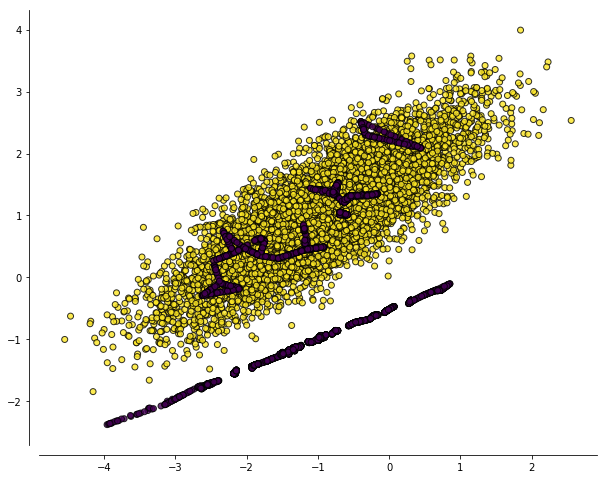

In [120]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(k_neighbors= 2, sampling_strategy= 0.5)

# Use smote to resample
x_smote, y_smote = smote.fit_resample(X_train,y_train)

plot_2d(x_smote,y_smote)

In [ ]:
smote_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True)

# Fit on oversampled data set
smote_model.fit(x_smote,y_smote)

#### Make Prior correction ###
# Get current intercept
smote_intercept = smote_model.intercept_

print('Corrected model intercept: ' + str(smote_intercept))


# Get population values as simple sample averages from the training sample
tau = sum(y_train) / len(y_train)

# Resampled population values
y_hat_smote = sum(y_smote) / len(y_smote)

# Rescale the intercept using the formula 
smote_corrected_intercept = current_intercept - np.log(  ((1-tau) / tau) *  (y_hat_smote / (1-y_hat_smote)))

print('Corrected model intercept: ' + str(corrected_intercept))

# Set corrected intercept as new model intercept
smote_model.intercept_ = smote_corrected_intercept

In [ ]:
y_smote_proba = smote_model.predict_proba(x_test)
y_smote_proba[::,1]

In [ ]:
y_smote_proba = smote_model.predict_proba(x_test)[::,1]


y_pred_smote = [1 if prob >= 0.01 else 0 for prob in y_smote_proba]

#y_pred_smote = smote_model.predict(x)

# Accuracy
accuracy = metrics.accuracy_score(y,y_pred_smote)
print(accuracy)
metrics.confusion_matrix(y,y_pred_smote)


In [ ]:
y_smote_proba = smote_model.predict_proba(x_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_smote_proba)
auc = metrics.roc_auc_score(y_test, y_smote_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### SMOTE with random under-sampling

In [118]:
# Under sample the data generated from smote using random under-sampling 
len(x_smote)

len(x_train)

NameError: name 'x_smote' is not defined

In [ ]:
sum(y_smote_ru) / len(y_smote_ru)

In [ ]:
smote_ru_model = LogisticRegression(solver='liblinear', max_iter= 100, fit_intercept= True)

# Fit on oversampled data set
smote_ru_model.fit(x_smote_ru,y_smote_ru)

## Correct intercept

# Get current intercept
smote_ru_intercept = smote_ru_model.intercept_

print('Un-corrected model intercept: ' + str(smote_ru_intercept))


# Get population values as simple sample averages from the training sample
tau = sum(y_train) / len(y_train)

# Resampled population values
y_hat_smote_ru = sum(y_smote_ru) / len(y_smote_ru)

# Rescale the intercept using the formula 
smote_ru_corrected_intercept = current_intercept - np.log(  ((1-tau) / tau) *  (y_hat_smote_ru / (1-y_hat_smote_ru)))

print('Corrected model intercept: ' + str(smote_ru_corrected_intercept))

# Set corrected intercept as new model intercept
smote_model.intercept_ = smote_ru_corrected_intercept

In [ ]:
smote_ru_proba

In [ ]:
# Make predictions on testing values
smote_ru_proba = smote_ru_model.predict_proba(x_test)

y_pred_smote_ru = [1 if prob >= 0.5 else 0 for prob in smote_ru_proba[::,1]]

# Accuracy
accuracy = metrics.accuracy_score(y_test,y_pred_smote_ru)
print(accuracy)
metrics.confusion_matrix(y_test,y_pred_smote_ru)


In [ ]:
smote_ru_proba = smote_ru_model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  smote_ru_proba)
auc = metrics.roc_auc_score(y_test, smote_ru_proba)
fig, ax = plt.subplots() 
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### XGBoost Baseline - Doesn't help much in this case!
- Shows that this is not only an issue for logistic regression
- I think the dataset is actually not informative at all

In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_tree, to_graphviz

In [ ]:
# fit model on training data
boost = XGBClassifier()

# Evaluation set
eval_set = [(x_train, y_train)]

# Fit the model
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
metrics.accuracy_score(y_test, predictions)


In [ ]:
# make predictions for test data
#y_pred = modelx.predict(x_test)
y_pred = model.predict(x_test)

In [ ]:
metrics.confusion_matrix(y_test,y_pred)

#### References 

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.
  
He, H., & Ma, Y. (Eds.). (2013). Imbalanced learning: foundations, algorithms, and applications. John Wiley & Sons.

G. Weiss (2013). Foundations of Imbalanced Learning, in Imbalanced learning: foundations, algorithms, and applications. edited by He, H., & Ma, Y.

Kuhn, M., & Johnson, K. (2013). Applied predictive modeling (Vol. 26). New York: Springer.
 